<center><b><font size=6>Machine Learning for Networks<b><center>

<left><b><font size=4>SSH Shell Attack session<b><left>                                                                   
##### Group 11

In [13]:
!pip install pyarrow
!pip install wordcloud

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score
# Models 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import multilabel_confusion_matrix, classification_report

<left><b><font size=4>Section 1 – Data exploration and pre-processing<b><left>

Dataset with all the SSH sessions

In [15]:
# Loading the dataset
df_original = pd.read_parquet('ssh_attacks.parquet')
df=df_original.copy()
df

,session_id,full_session,first_timestamp,Set_Fingerprint
0,0,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:45:11.151186+00:00,"[Defense Evasion, Discovery]"
1,1,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:45:50.396610+00:00,"[Defense Evasion, Discovery]"
2,2,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:54:41.863315+00:00,"[Defense Evasion, Discovery]"
3,3,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 10:22:14.623875+00:00,"[Defense Evasion, Discovery]"
4,4,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 10:37:19.725874+00:00,"[Defense Evasion, Discovery]"
...,...,...,...,...
233030,233042,cat /proc/cpuinfo | grep name | wc -l ; echo -...,2020-02-29 23:47:28.217237+00:00,"[Discovery, Persistence]"
233031,233043,cat /proc/cpuinfo | grep name | wc -l ; echo -...,2020-02-29 23:49:01.009046+00:00,"[Discovery, Persistence]"
233032,233044,cat /proc/cpuinfo | grep name | wc -l ; echo -...,2020-02-29 23:56:18.827281+00:00,"[Discovery, Persistence]"
233033,233045,cat /proc/cpuinfo | grep name | wc -l ; echo -...,2020-02-29 23:56:56.263104+00:00,"[Discovery, Persistence]"


**1. When are the attacks performed? Analyze the temporal series.**

In [16]:
# Convert 'first_timestamp' column to datetime objects
df['first_timestamp'] = pd.to_datetime(df['first_timestamp'])

# Creating a new DataFrame containing only attack instances
# Excluding sessions labeled as "Harmless" with a single label
df_attacks = df.loc[~df["Set_Fingerprint"].apply(lambda x : "Harmless" in x and len(x) == 1)]

# Count the number of attacks per day
# Extract the date from 'first_timestamp', count occurrences, sort by date
attacks_per_day = df_attacks['first_timestamp'].dt.date.value_counts().sort_index().to_frame("Number_of_attacks_per_day")

# Display the resulting DataFrame showing the number of attacks per day
attacks_per_day

,Number_of_attacks_per_day
first_timestamp,
2019-06-04,82
2019-06-05,124
2019-06-06,117
2019-06-07,121
2019-06-08,118
...,...
2020-02-25,649
2020-02-26,483
2020-02-27,551


The analysis of attack occurrences based on the temporal series of first_timestamp showcases a trend in attack frequency over time.
The dataset has been transformed to interpret the first_timestamp column as datetime objects for accurate temporal analysis. The subsequent process isolates attack instances within the dataset, excluding records tagged as "Harmless" with a single label.
The resulting analysis presents the number of attacks per day:

| Date_time | Attacks |
| --- | --- |
|June 4th, 2019 | 82 attacks |
|June 5th, 2019 | 124 attacks |
|June 6th, 2019 | 117 attacks |
|June 7th, 2019 | 121 attacks |
|June 8th, 2019 | 118 attacks |
| ... (continues with dates up to) |
| February 25th, 2020| 649 attacks |
| February 26th, 2020| 483 attacks |
| February 27th, 2020| 551 attacks |
| February 28th, 2020| 580 attacks |
| February 29th, 2020| 627 attacks |

This temporal series reveals fluctuations in attack intensity over time, with notable spikes and drops in attack occurrences. The observations suggest potential patterns or trends that could be further explored to understand the dynamics of these SSH shell attacks across different periods.

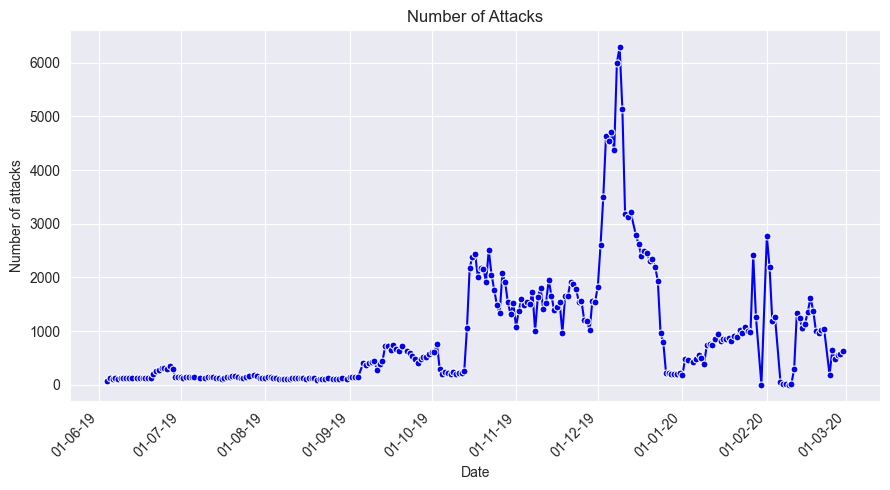

In [17]:
# Set the figure size for the plot
plt.figure(figsize=(9,5))
sns.set_style("darkgrid")

# Create a line plot using seaborn
sns.lineplot(
    data = attacks_per_day,          # Use the 'attacks_per_day' DataFrame for plotting
    x = attacks_per_day.index,       # X-axis represents the timestamp of attacks
    y = "Number_of_attacks_per_day", # Y-axis represents the number of attacks per day
    marker='o',                      # Marker style for data points
    linestyle='-',                   # Style of the line connecting the data points
    color= 'blue',                   # Color of the line
    markersize=5                     # Size of markers
)

# Set plot title and labels for axes
plt.title('Number of Attacks')
plt.xlabel("Date")
plt.ylabel("Number of attacks")

# Format the date on the x-axis to display day-month-year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
plt.xticks(rotation=45, ha='right')

# Ensure proper layout and display the plot
plt.tight_layout()
plt.show()

The visualization depicting attack frequencies over time reveals distinct patterns:

Between June 2019 and September 2019, there is a conspicuous decrease in attack occurrences, indicating a phase of minimal activity. Subsequently, there is a significant surge in attack instances towards the latter part of 2019, signifying a notable rise in both the frequency and intensity of attacks during this period.

This timeline underscores a stark contrast between the relatively quiet phase observed from June to September 2019 and the pronounced escalation in attack activities, particularly notable in the latter months of the year. This shift in trend emphasizes a substantial alteration in attack behavior, marked by an extended period of low activity succeeded by a considerable surge in attack incidents towards the year's end.

Moreover, at the beginning of 2020, there is a noticeable decline in attack occurrences once more. This decline follows the heightened activity observed in late 2019, representing a shift from the increased attack rates back to a decreased frequency as the year transitions into its initial months.

In [18]:
#This code aggregates attack instances per year, creating a DataFrame named attacks_per_year

# Group attack instances by year and count occurrences
attacks_per_year = df_attacks.groupby(df['first_timestamp'].dt.year).size().to_frame("Number_attacks").reset_index()

# Rename columns for clarity
attacks_per_year.rename(columns={"first_timestamp": "Year"}, inplace=True)
attacks_per_year

,Year,Number_attacks
0,2019,186468
1,2020,46342


The contrast in attack counts between the two years, with 2019 showing a significantly higher number of attacks compared to 2020, can be reasonably attributed to the limited temporal coverage of the dataset for the year 2020. With data available for only two months of 2020, the reduced number of observations in this period is expected and explains the lower count of attacks for that year compared to the extensive records available for 2019.

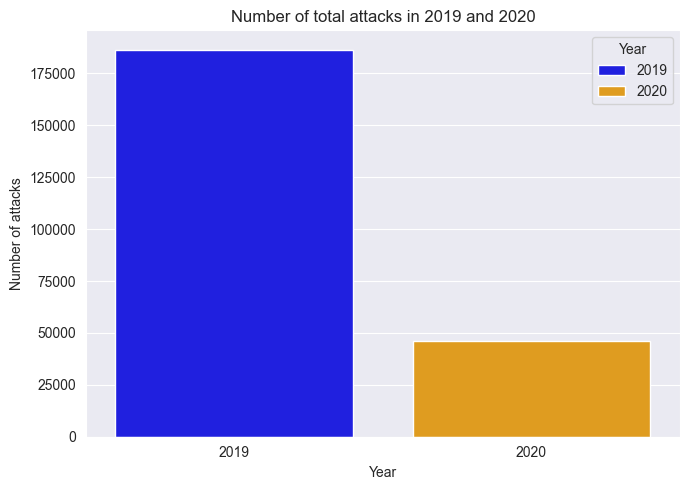

In [19]:
# Set the figure size for the plot
plt.figure(figsize=(7,5))

# Set the figure size for the plot
sns.barplot(
    data = attacks_per_year,   # Use the 'attacks_per_year' DataFrame for plotting
    x = "Year",                # X-axis represents the years (2019 and 2020)
    y = "Number_attacks",      # Y-axis represents the number of attacks
    hue= "Year",
    palette = ['blue','orange']
)

# Set plot labels and title
plt.ylabel("Number of attacks")
plt.title("Number of total attacks in 2019 and 2020")

# Display the plot
plt.tight_layout()
plt.show()

In [20]:
# Filter attack instances for the year 2019
df_attacks_2019 = df_attacks.loc[df_attacks["first_timestamp"].dt.year == 2019]
# Group attacks by month and count occurrences
df_attacks_2019_month = df_attacks_2019.groupby(df_attacks_2019["first_timestamp"].dt.month).size().to_frame("Number_attacks_2019_month").reset_index()

# Filter attack instances for the year 2020
df_attacks_2020 = df_attacks.loc[df_attacks["first_timestamp"].dt.year == 2020]
# Group attacks by month and count occurrences
df_attacks_2020_month = df_attacks_2020.groupby(df_attacks_2020["first_timestamp"].dt.month).size().to_frame("Number_attacks_2020_month").reset_index()

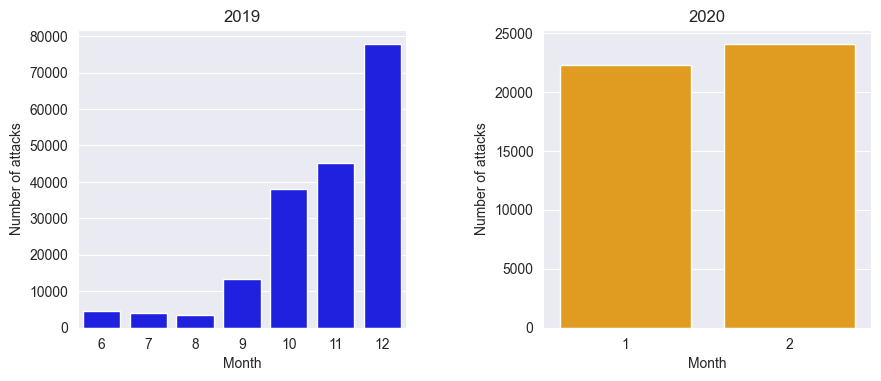

In [21]:
# Set up a figure with two subplots
plt.figure(figsize=(10,5))
sns.set_style("darkgrid")

# Plot for 2019
plt.subplot(1,2,1)
sns.barplot(
    data = df_attacks_2019_month,
    x = "first_timestamp",
    y = "Number_attacks_2019_month",
    color = 'blue'  
)
plt.xlabel("Month")
plt.ylabel("Number of attacks")
plt.title("2019")

# Plot for 2020
plt.subplot(1,2,2)
sns.barplot(
    data = df_attacks_2020_month,
    x = "first_timestamp",
    y = "Number_attacks_2020_month",
    color = 'orange'
)
plt.xlabel("Month")
plt.ylabel("Number of attacks")
plt.title("2020")

# Adjust layout and display the plot
plt.tight_layout(pad = 5)
plt.show()

The bar charts reveal intriguing trends:

- In 2019, there is a noticeable surge in the number of attacks from months 9 to 12. A progressive increase in attack activity is observed during these months, reaching a peak towards the year's end.

- At the onset of 2020, in months 1 and 2, a relatively similar frequency of attacks is noted, approximately representing half the number of attacks compared to month 10 in 2019.

These patterns outline a significant uptick in attack activity towards the end of 2019, followed by a comparatively steady beginning in 2020 with a considerably lower number of attacks compared to the peak period of the previous year.

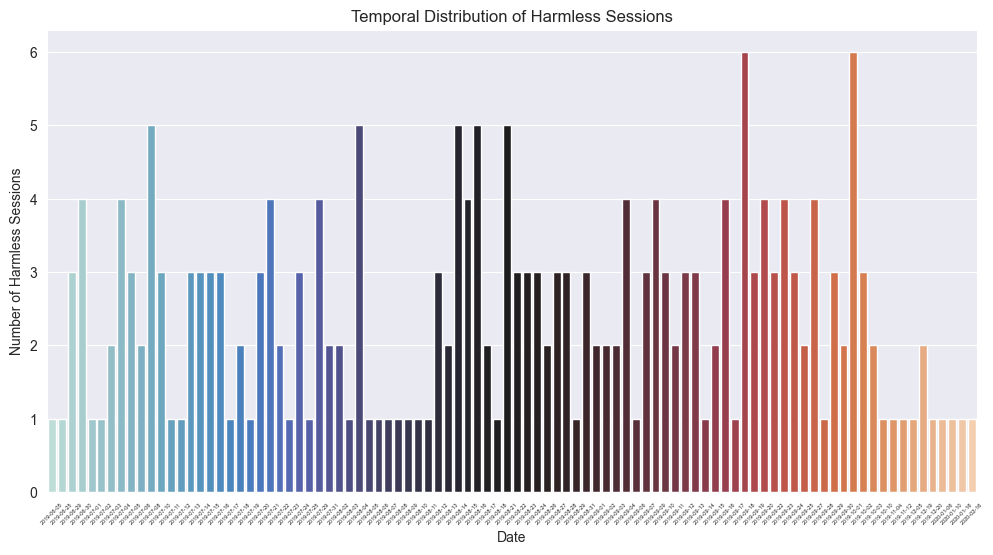

In [22]:
# Filtering harmless sessions based on 'Set_Fingerprint' column
df_harmless = df[df["Set_Fingerprint"].apply(lambda x : "Harmless" in x and len(x) == 1)]

# Counting harmless sessions per day
harmless_per_day = df_harmless['first_timestamp'].dt.date.value_counts().sort_index().to_frame("Number_harmless_per_day")

# Creating a bar plot
plt.figure(figsize=(12, 6))
sns.set_style("darkgrid")
sns.barplot(
    data = harmless_per_day,
    x = harmless_per_day.index, 
    y = "Number_harmless_per_day",
    hue = harmless_per_day.index,
    legend = False,
    palette = "icefire"
)
plt.title('Temporal Distribution of Harmless Sessions')
plt.xlabel('Date')
plt.ylabel('Number of Harmless Sessions')
plt.xticks(rotation = 45, fontsize = 4)  # Rotate x-axis labels by 45 degrees

plt.show()

**1.2. Extract features from the attack sessions. How does the empirical distribution of the number of
characters in each session look like? How is the distribution of the number of word per session?**

In [23]:
# Add number of characters and words as features
# Number_characters: Calculates the number of alphanumeric characters in each session.
df['number_characters'] = df['full_session'].apply(lambda x: len([char for char in x if char.isalpha()]))

# Number_words: Computes the number of words (considering only alphanumeric characters) in each session.
df['number_words'] = df['full_session'].apply(lambda x: len([char for char in x.split() if char.isalpha()]))

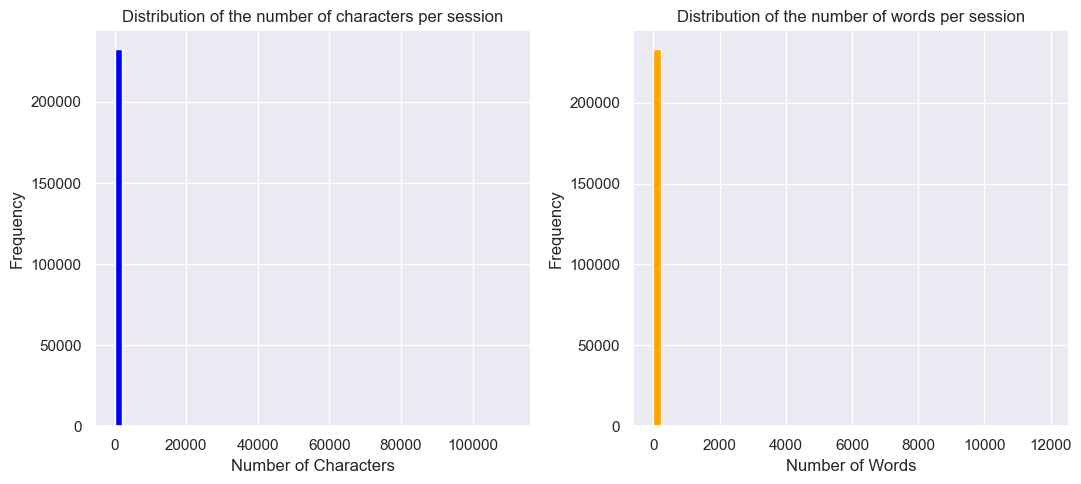

In [69]:
# This code creates two side-by-side histograms:
# Histogram of Character Counts per Session: Displays the distribution of the number of characters in each session. It bins the data into 50 bins.
# Histogram of Word Counts per Session: Shows the distribution of the number of words in each session. It also bins the data into 50 bins.
# These histograms help visualize the distributions of character and word counts within the attack sessions, providing insights into the length and complexity of these sessions in terms of characters and words. 

# Tracking histograms for character and word counts per session.
plt.figure(figsize=(11, 5))

# Histogram for the number of characters per session.
plt.subplot(1, 2, 1)
sns.set_style("darkgrid")
plt.hist(df['number_characters'], bins=50, color = 'blue')
plt.title('Distribution of the number of characters per session')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')


# Histogram for the number of words per session
plt.subplot(1, 2, 2)
plt.hist(df['number_words'], bins = 50 , color = 'orange') 
plt.title('Distribution of the number of words per session')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')


plt.tight_layout()
plt.show()

From the plot, it's possible to see that the distribution of words per session and the distribution of characters per session predominantly concentrate below 2000 words and below 20,000 characters, respectively.

To have a clearer idea of the distribution, we decided to limit the x-axis for both plots so that we can closely examine these two distributions

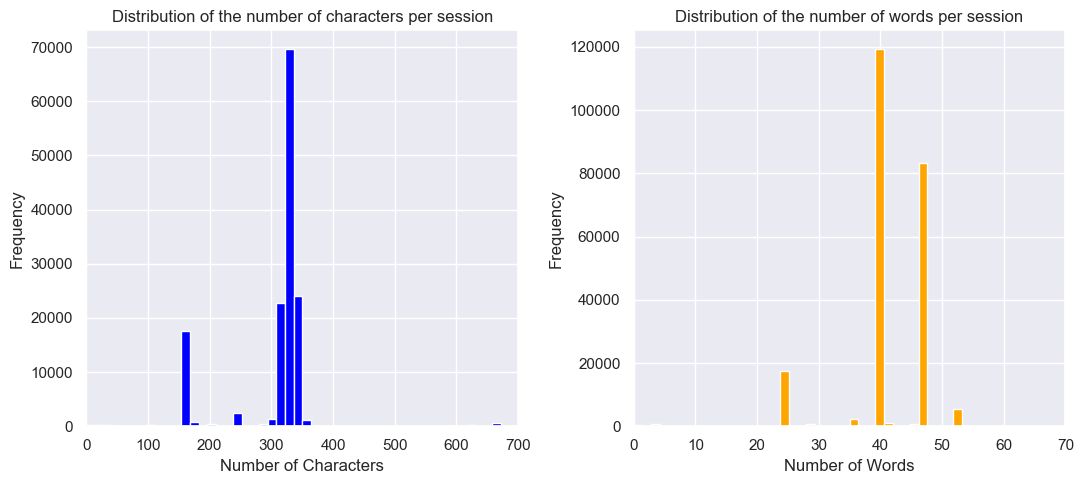

In [70]:
# Tracking histograms for character and word counts per session.
plt.figure(figsize=(11, 5))

# Histogram for the number of characters per session.
plt.subplot(1, 2, 1)
sns.set_style("darkgrid")
plt.hist(df['number_characters'], bins=50, range=(0, 700), color = 'blue') #
plt.title('Distribution of the number of characters per session')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.xlim(0, 700)

# Histogram for the number of words per session
plt.subplot(1, 2, 2)
plt.hist(df['number_words'], bins = 50, range = (0, 70) , color = 'orange') #
plt.title('Distribution of the number of words per session')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.xlim(0, 70)

plt.tight_layout()
plt.show()

From the histograms, it is observed that the distribution of character counts per session centers is concentrated around approximately 350 characters.
Moreover, regarding the number of words per session, the distribution frequently peaks around 40 to 48 words. This indicates that sessions often contain this range of word counts, emphasizing a typical occurrence of sessions with this word count range. These insights provide a clear understanding of the common lengths observed within the attack sessions, both in terms of characters and words.

**1.3. What are the most common words in the sessions?**

In [25]:
# Extracting the 'full_session' column from the DataFrame
df_words = df['full_session']

# Joining all text from 'full_session' into a single string
all_text = ' '.join(df['full_session'])

# Splitting the text into individual words
all_words = all_text.split()

# Cleaning the text, leaving only alpha numeric words
cleaning_text = [all_words[i] for i in range(len(all_words)) if all_words[i].isalpha()] 

In [26]:
# Count the occurrences of each word and extract the top 10 most common words
df_list = pd.Series(cleaning_text).value_counts().head(10)

# Identify the most common word and its frequency
most_common_word = df_list.idxmax()    # Most common word
frequency = df_list.max()              # Frequency of the most common word

# Convert the Series of word frequencies to a dictionary
word_freq=df_list.to_dict()
most_common_word

'grep'

The most common word is : 'grep'

In [27]:
# dictionary that holds the frequencies of the top 10 most common words
word_freq

{'grep': 1278484,
 'cat': 1082651,
 'echo': 957748,
 'uname': 639136,
 'name': 638772,
 'rm': 451423,
 'awk': 426372,
 'head': 425586,
 'wc': 425581,
 'ls': 305296}

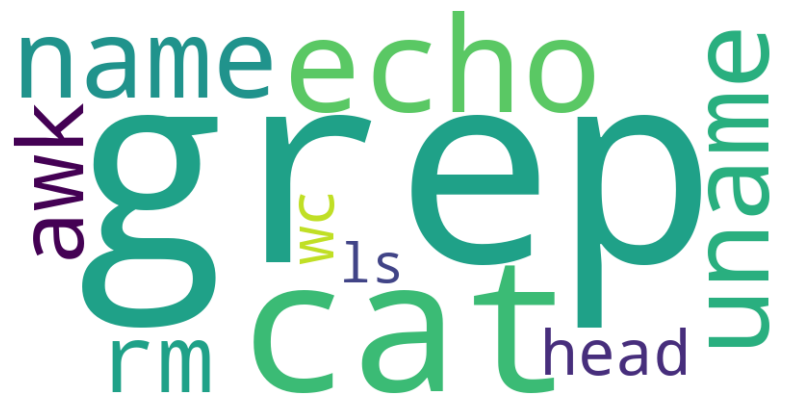

In [28]:
# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Display the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

 This representation emphasizes words based on their frequency in the sessions. Words that appear more frequently will be displayed larger and more prominently within the WordCloud. The interpolation='bilinear' argument enhances the image quality for better clarity. The plt.axis('off') command removes the axis for a cleaner visual appearance.

**1.4. How are the intents distributed? How many intents per session do you observe? What are the most common intents? How are the intents distributed in time?**

<Axes: title={'center': 'Number of Intents per Sessions'}, xlabel='Sessions', ylabel='Number of Intents'>

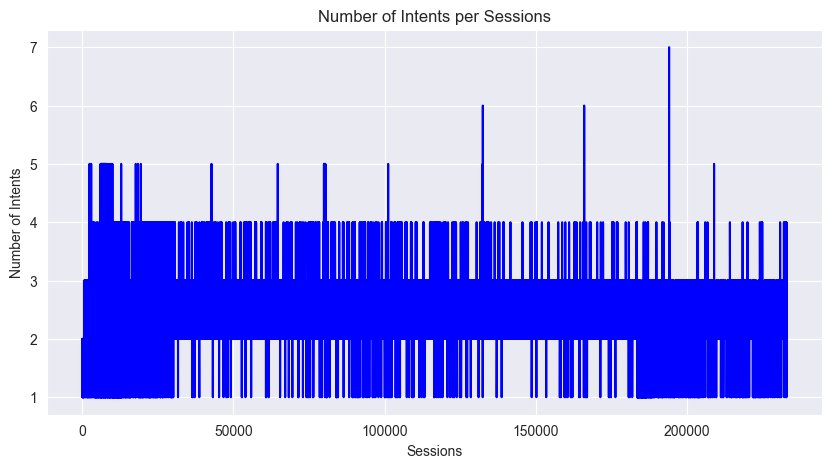

In [29]:
# Extracting relevant columns: session_id and Set_Fingerprint
intents_df = df[["session_id", "Set_Fingerprint"]]

# Expanding the 'Set_Fingerprint' column to individual intents and sessions
intents_df_exploted = intents_df.explode('Set_Fingerprint')

# Grouping by session and counting the number of intents per session
intents_df_grouped = intents_df_exploted.groupby("session_id").size()

# Plotting the distribution of intents per session
intents_df_grouped.plot(
    figsize = (10,5), 
    xlabel = "Sessions", 
    ylabel = "Number of Intents", 
    title = "Number of Intents per Sessions",
    color = 'blue')

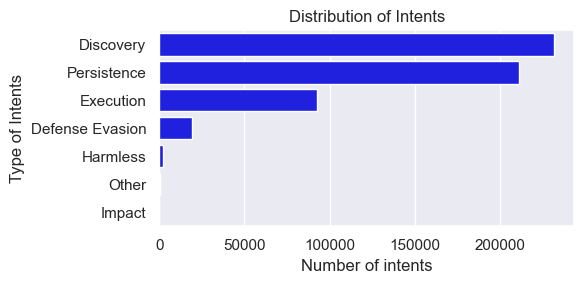

In [30]:
intents = intents_df_exploted.groupby('Set_Fingerprint').count().sort_values(by='session_id', ascending=False)

# Distribution plot of intents 
# Set up Seaborn style
sns.set(style="darkgrid")

# Generate the figures
plt.figure(figsize=(6,3))
sns.barplot(intents, x='session_id', y=intents.index, color='blue', hue_order=intents.index)
plt.title('Distribution of Intents')
plt.xlabel('Number of intents')
plt.ylabel('Type of Intents')

# Show the plot
plt.tight_layout()
plt.show()

The presented bar chart shows the most common intentions found in the dataset; Discovery, Persistence and Execution lead the most used type of attacks for each of the sessions.

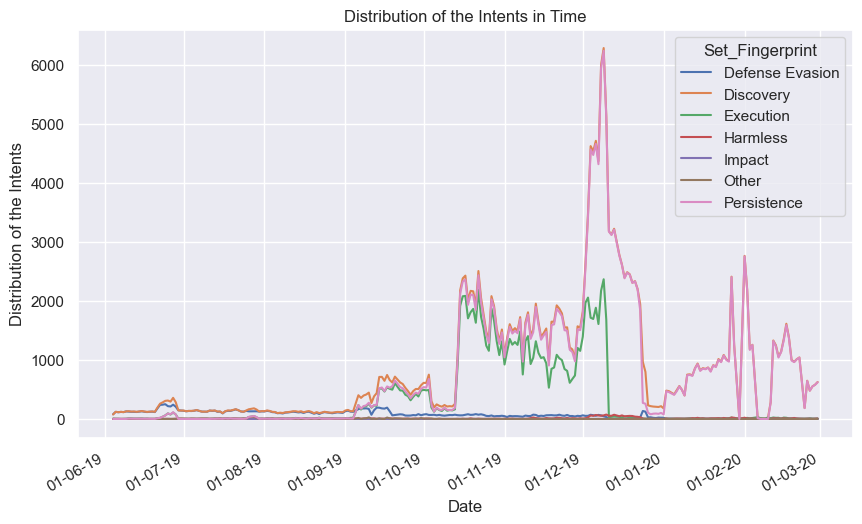

In [31]:
# Explode the 'Set_Fingerprint' column and group by timestamp and intents, filling missing values with 0
df_grouped = df.explode('Set_Fingerprint').groupby([pd.Grouper(key='first_timestamp', freq='D'), 'Set_Fingerprint']).size().unstack().fillna(0)

# Plotting the distribution of intents over time
df_grouped.plot(
    figsize = (10,6), 
    xlabel = "Date", 
    ylabel = "Distribution of the Intents", 
    title = "Distribution of the Intents in Time")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))

The distribution of intents unfolds as follows:

**Defense Evasion**:
No significant peaks noticed, with a few attacks observed between July and September 2019, remaining consistently low alongside 'Harmless', 'Impact', and 'Other' intents.

**Execution**:
Displays a sharp peak towards the end of 2019, notably in the last two months.

**Persistence and Discovery**:
Showcase an intriguing trend, reaching their highest peaks towards the end of 2019. These intents exhibit the highest frequency, notably surging towards the year-end, reaching maximum levels.

**1.5. How can text represented numerically? Try to convert the text into numerical representations
(vectors) through Bag of Words (BoW)**

In [32]:
stop_words = set()
df['full_session'].apply(lambda x: [stop_words.add(character) for character in x if not character.isalpha()])

0         [None, None, None, None, None, None, None, Non...
1         [None, None, None, None, None, None, None, Non...
2         [None, None, None, None, None, None, None, Non...
3         [None, None, None, None, None, None, None, Non...
4         [None, None, None, None, None, None, None, Non...
                                ...                        
233030    [None, None, None, None, None, None, None, Non...
233031    [None, None, None, None, None, None, None, Non...
233032    [None, None, None, None, None, None, None, Non...
233033    [None, None, None, None, None, None, None, Non...
233034    [None, None, None, None, None, None, None, Non...
Name: full_session, Length: 233035, dtype: object

In [33]:
stop_words

{'\x01',
 '\x07',
 '\x0f',
 '\x14',
 '\x16',
 '\x18',
 '\x1a',
 '\x1b',
 ' ',
 '!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~'}

In [34]:
count_vectorizer = CountVectorizer(stop_words = list(stop_words), min_df = 0.05, max_df = 0.95)
bow = count_vectorizer.fit_transform(df["full_session"])
df["bag_of_words"] = pd.Series(bow.toarray().tolist())
df

,session_id,full_session,first_timestamp,Set_Fingerprint,number_characters,number_words,bag_of_words
0,0,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:45:11.151186+00:00,"[Defense Evasion, Discovery]",167,24,"[0, 0, 1, 0, 0, 0, 0, 5, 1, 4, 1, 0, 1, 1, 0, ..."
1,1,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:45:50.396610+00:00,"[Defense Evasion, Discovery]",167,24,"[0, 0, 1, 0, 0, 0, 0, 5, 1, 4, 1, 0, 1, 1, 0, ..."
2,2,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:54:41.863315+00:00,"[Defense Evasion, Discovery]",167,24,"[0, 0, 1, 0, 0, 0, 0, 5, 1, 4, 1, 0, 1, 1, 0, ..."
3,3,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 10:22:14.623875+00:00,"[Defense Evasion, Discovery]",167,24,"[0, 0, 1, 0, 0, 0, 0, 5, 1, 4, 1, 0, 1, 1, 0, ..."
4,4,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 10:37:19.725874+00:00,"[Defense Evasion, Discovery]",167,24,"[0, 0, 1, 0, 0, 0, 0, 5, 1, 4, 1, 0, 1, 1, 0, ..."
...,...,...,...,...,...,...,...
233030,233042,cat /proc/cpuinfo | grep name | wc -l ; echo -...,2020-02-29 23:47:28.217237+00:00,"[Discovery, Persistence]",312,40,"[0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, ..."
233031,233043,cat /proc/cpuinfo | grep name | wc -l ; echo -...,2020-02-29 23:49:01.009046+00:00,"[Discovery, Persistence]",329,40,"[0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, ..."
233032,233044,cat /proc/cpuinfo | grep name | wc -l ; echo -...,2020-02-29 23:56:18.827281+00:00,"[Discovery, Persistence]",337,40,"[0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, ..."
233033,233045,cat /proc/cpuinfo | grep name | wc -l ; echo -...,2020-02-29 23:56:56.263104+00:00,"[Discovery, Persistence]",324,40,"[0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, ..."


**1.6. Associate each word in each attack session with its TF-IDF value (Term Frequency-Inverse Document Frequency)**

In [35]:
tfidf_vectorizer = TfidfVectorizer(stop_words=list(stop_words), min_df=0.05, max_df=0.95)
tfid = tfidf_vectorizer.fit_transform(df["full_session"])
df["tfid"] = pd.Series(tfid.toarray().tolist())
df

,session_id,full_session,first_timestamp,Set_Fingerprint,number_characters,number_words,bag_of_words,tfid
0,0,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:45:11.151186+00:00,"[Defense Evasion, Discovery]",167,24,"[0, 0, 1, 0, 0, 0, 0, 5, 1, 4, 1, 0, 1, 1, 0, ...","[0.0, 0.0, 0.1283154980776484, 0.0, 0.0, 0.0, ..."
1,1,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:45:50.396610+00:00,"[Defense Evasion, Discovery]",167,24,"[0, 0, 1, 0, 0, 0, 0, 5, 1, 4, 1, 0, 1, 1, 0, ...","[0.0, 0.0, 0.1283154980776484, 0.0, 0.0, 0.0, ..."
2,2,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:54:41.863315+00:00,"[Defense Evasion, Discovery]",167,24,"[0, 0, 1, 0, 0, 0, 0, 5, 1, 4, 1, 0, 1, 1, 0, ...","[0.0, 0.0, 0.1283154980776484, 0.0, 0.0, 0.0, ..."
3,3,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 10:22:14.623875+00:00,"[Defense Evasion, Discovery]",167,24,"[0, 0, 1, 0, 0, 0, 0, 5, 1, 4, 1, 0, 1, 1, 0, ...","[0.0, 0.0, 0.1283154980776484, 0.0, 0.0, 0.0, ..."
4,4,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 10:37:19.725874+00:00,"[Defense Evasion, Discovery]",167,24,"[0, 0, 1, 0, 0, 0, 0, 5, 1, 4, 1, 0, 1, 1, 0, ...","[0.0, 0.0, 0.1283154980776484, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
233030,233042,cat /proc/cpuinfo | grep name | wc -l ; echo -...,2020-02-29 23:47:28.217237+00:00,"[Discovery, Persistence]",312,40,"[0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, ...","[0.0, 0.07828651838121202, 0.0, 0.117615255528..."
233031,233043,cat /proc/cpuinfo | grep name | wc -l ; echo -...,2020-02-29 23:49:01.009046+00:00,"[Discovery, Persistence]",329,40,"[0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, ...","[0.0, 0.07828651838121202, 0.0, 0.117615255528..."
233032,233044,cat /proc/cpuinfo | grep name | wc -l ; echo -...,2020-02-29 23:56:18.827281+00:00,"[Discovery, Persistence]",337,40,"[0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, ...","[0.0, 0.07828651838121202, 0.0, 0.117615255528..."
233033,233045,cat /proc/cpuinfo | grep name | wc -l ; echo -...,2020-02-29 23:56:56.263104+00:00,"[Discovery, Persistence]",324,40,"[0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, ...","[0.0, 0.07828651838121202, 0.0, 0.117615255528..."


In [36]:
tfidf_df = pd.DataFrame(tfid.toarray(), index=df["full_session"].index, columns = list(tfidf_vectorizer.vocabulary_.keys()))
# Concatenate along columns (axis=1)
result_df = pd.concat([df, tfidf_df], axis=1)
result_df

,session_id,full_session,first_timestamp,Set_Fingerprint,number_characters,number_words,bag_of_words,tfid,enable,system,...,passwd,admin,up,txt,15s,dota,systemcache436621,iyevymlul2jhc2gky2qgl3rtcakkcm0glxjmic5zc2gkcm0glxjmic5tb3vudgzzcnjtic1yziauwdezlxvuaxgkcm0glxjmic5ymtctdw5peapta2rpciauwde3lxvuaxgky2qgllgxny11bml4cm12ic92yxivdg1wl2rvdgeudgfylmd6igrvdgeudgfylmd6cnrhcib4zibkb3rhlnrhci5negpzbgvlccazcyamjibjzcavdg1wly5ymtctdw5pec8ucnn5bmmvywpub2h1ccavdg1wly5ymtctdw5pec8ucnn5bmmvyy90c20glxqgmtuwic1tidyglxmgniatccaymiatucawic1midaglwsgmsatbcaxic1pidagl3rtcc91cc50ehqgmtkylje2oca,piavzgv2l251bgwgmj4xjgpzbgvlcca4bsamjibub2h1ccavdg1wly5ymtctdw5pec8ucnn5bmmvyy90c20glxqgmtuwic1tidyglxmgniatccaymiatucawic1midaglwsgmsatbcaxic1pidagl3rtcc91cc50ehqgmtcylje2id4,ic9kzxyvbnvsbcaypjemcnnszwvwidiwbsamjibjzcauljsgl3rtcc8uwde3lxvuaxgvlnjzew5jl2luaxrhbgwgmj4xjgplegl0ida
0,0,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:45:11.151186+00:00,"[Defense Evasion, Discovery]",167,24,"[0, 0, 1, 0, 0, 0, 0, 5, 1, 4, 1, 0, 1, 1, 0, ...","[0.0, 0.0, 0.1283154980776484, 0.0, 0.0, 0.0, ...",0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.126899,0.000000,0.128291
1,1,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:45:50.396610+00:00,"[Defense Evasion, Discovery]",167,24,"[0, 0, 1, 0, 0, 0, 0, 5, 1, 4, 1, 0, 1, 1, 0, ...","[0.0, 0.0, 0.1283154980776484, 0.0, 0.0, 0.0, ...",0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.126899,0.000000,0.128291
2,2,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:54:41.863315+00:00,"[Defense Evasion, Discovery]",167,24,"[0, 0, 1, 0, 0, 0, 0, 5, 1, 4, 1, 0, 1, 1, 0, ...","[0.0, 0.0, 0.1283154980776484, 0.0, 0.0, 0.0, ...",0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.126899,0.000000,0.128291
3,3,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 10:22:14.623875+00:00,"[Defense Evasion, Discovery]",167,24,"[0, 0, 1, 0, 0, 0, 0, 5, 1, 4, 1, 0, 1, 1, 0, ...","[0.0, 0.0, 0.1283154980776484, 0.0, 0.0, 0.0, ...",0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.126899,0.000000,0.128291
4,4,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 10:37:19.725874+00:00,"[Defense Evasion, Discovery]",167,24,"[0, 0, 1, 0, 0, 0, 0, 5, 1, 4, 1, 0, 1, 1, 0, ...","[0.0, 0.0, 0.1283154980776484, 0.0, 0.0, 0.0, ...",0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.126899,0.000000,0.128291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233030,233042,cat /proc/cpuinfo | grep name | wc -l ; echo -...,2020-02-29 23:47:28.217237+00:00,"[Discovery, Persistence]",312,40,"[0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, ...","[0.0, 0.07828651838121202, 0.0, 0.117615255528...",0.0,0.078287,...,0.077864,0.078897,0.234074,0.078919,0.311856,0.234861,0.15596,0.000000,0.078032,0.000000
233031,233043,cat /proc/cpuinfo | grep name | wc -l ; echo -...,2020-02-29 23:49:01.009046+00:00,"[Discovery, Persistence]",329,40,"[0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, ...","[0.0, 0.07828651838121202, 0.0, 0.117615255528...",0.0,0.078287,...,0.077864,0.078897,0.234074,0.078919,0.311856,0.234861,0.15596,0.000000,0.078032,0.000000
233032,233044,cat /proc/cpuinfo | grep name | wc -l ; echo -...,2020-02-29 23:56:18.827281+00:00,"[Discovery, Persistence]",337,40,"[0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, ...","[0.0, 0.07828651838121202, 0.0, 0.117615255528...",0.0,0.078287,...,0.077864,0.078897,0.234074,0.078919,0.311856,0.234861,0.15596,0.000000,0.078032,0.000000
233033,233045,cat /proc/cpuinfo | grep name | wc -l ; echo -...,2020-02-29 23:56:56.263104+00:00,"[Discovery, Persistence]",324,40,"[0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, ...","[0.0, 0.07828651838121202, 0.0, 0.117615255528...",0.0,0.078287,...,0.077864,0.078897,0.234074,0.078919,0.311856,0.234861,0.15596,0.000000,0.078032,0.000000


<left><b><font size=4>Section 2 – Supervised Learning – Classification<b><left>

**Classify the tactics of an attack session, based on the used words in the text and also possibly on time. Notice that each session have multiple labels. Hence you can decompose the problem into multiple binary classification problems. For each attack session, you have to solve the 7 binary classification problem, one for each possible label {'Persistence', 'Discovery', 'Defense Evasion', 'Execution', 'Impact', 'Other', 'Harmless'}.**

In [37]:
df_class = result_df.copy()
print(df_class)

        session_id                                       full_session  \
0                0  enable ; system ; shell ; sh ; cat /proc/mount...   
1                1  enable ; system ; shell ; sh ; cat /proc/mount...   
2                2  enable ; system ; shell ; sh ; cat /proc/mount...   
3                3  enable ; system ; shell ; sh ; cat /proc/mount...   
4                4  enable ; system ; shell ; sh ; cat /proc/mount...   
...            ...                                                ...   
233030      233042  cat /proc/cpuinfo | grep name | wc -l ; echo -...   
233031      233043  cat /proc/cpuinfo | grep name | wc -l ; echo -...   
233032      233044  cat /proc/cpuinfo | grep name | wc -l ; echo -...   
233033      233045  cat /proc/cpuinfo | grep name | wc -l ; echo -...   
233034      233046  cat /proc/cpuinfo | grep name | wc -l ; echo -...   

                        first_timestamp               Set_Fingerprint  \
0      2019-06-04 09:45:11.151186+00:00  [Defense 

**2.1 Perform a split to segment the dataset into training and test dataset. If you want to standardize your dataset, fit the scaler on training set and transforming both training and test. Notice that the sklearn implementation of tf-idf already performs the standardization.**

In [38]:
features_names = tfidf_df.columns

X_feature = df_class.filter(features_names)
y_feature =  df_class["Set_Fingerprint"]

X_train, X_test, y_train, y_test = train_test_split(
    X_feature,
    y_feature,
    train_size = 0.7,             # 70% of the data is for trainning
    random_state = 42)

In [39]:
print('The size of trainning set is:', len(X_train))
print('The size of test set is:', len(X_test))

The size of trainning set is: 163124
The size of test set is: 69911


### Data Preprocessing

##### Standardization of the Numerical Features

As the TF-IDF pre-processing was applied previously to all sessions, the data considered as features are already standardized. 

##### Standardization of the Categorical Features

In [40]:
from sklearn.preprocessing import MultiLabelBinarizer

# Use MultiLabelBinarizer to transform the labels
mlb = MultiLabelBinarizer()
y_train_mlb = mlb.fit_transform(y_train)
y_test_mlb = mlb.transform(y_test)

**Preprocessing Techniques** 
<br>
<div style="text-align: justify"> A <b>MultiLabelBinarizer</b> is a transformer that is used for multi-label classification problems, in order to handle the cases where each sample belongs to multiple classes simultaneously. The purpose of MultiLabelBinarizer is to convert a collection of sequences of labels into a binary matrix format. The binary classification of each label in the 'Set_Fingerprint' column was performed by converting the multi-class label matrix into a binary matrix, where each column represents one of the possible classes and each row represents one instance. </div><br>

<div style="text-align: justify"> <b>TF-IDF </b> (explain technique here) </div><br>

<div style="text-align: justify"> MultiLabelBinarizer is used to handle categorical variables before fitting a model, as most machine learning algorithms can only handle numerical data.</div><br>


**2.2 Choose at least 2 ML methods, and perform the model training, with default parameter
configuration, evaluating the performance on both training and test set. Output the confusion
matrix and classification report. Do you observe overfitting or under-fitting? Which model
generates the best performance?**

<left><b><font size=4> First ML Method <b><left>

**Random Forest (RF)**

In [41]:
model_rf = RandomForestClassifier(n_estimators=30, max_depth=15)
# Trainning the model
model_rf.fit(X_train, y_train_mlb)

RandomForestClassifier(max_depth=15, n_estimators=30)

In [42]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions on training set
y_train_pred = model_rf.predict(X_train)

# Predictions on test set
y_test_pred = model_rf.predict(X_test)

**Classification Report**

##### Training Set

In [43]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Evaluate performance on training set
report_trainning = classification_report(y_train_mlb.argmax(axis=1), y_train_pred.argmax(axis=1), output_dict=True)
df_report_trainning = pd.DataFrame(report_trainning).transpose()
df_report_trainning

C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_clas

,precision,recall,f1-score,support
0,0.992528,0.973962,0.983157,13365.000000
1,0.997632,0.999437,0.998534,149246.000000
2,0.954416,0.979532,0.966811,342.000000
3,0.992958,0.886792,0.936877,159.000000
4,0.000000,0.000000,0.000000,2.000000
5,0.000000,0.000000,0.000000,3.000000
6,0.000000,0.000000,0.000000,7.000000
accuracy,0.997125,0.997125,0.997125,0.997125
macro avg,0.562505,0.548532,0.555054,163124.000000
weighted avg,0.997046,0.997125,0.997074,163124.000000


##### Validation Set (Test set)

In [44]:
# Evaluate performance on test set
report_test = classification_report(y_test_mlb.argmax(axis=1), y_test_pred.argmax(axis=1), output_dict=True)
df_report_test = pd.DataFrame(report_test).transpose()
df_report_test

C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_clas

,precision,recall,f1-score,support
0,0.990563,0.968761,0.979541,5634.00000
1,0.997134,0.999251,0.998192,64074.00000
2,0.945312,0.909774,0.927203,133.00000
3,0.984127,0.911765,0.946565,68.00000
5,0.000000,0.000000,0.000000,1.00000
6,0.000000,0.000000,0.000000,1.00000
accuracy,0.996510,0.996510,0.996510,0.99651
macro avg,0.652856,0.631592,0.641917,69911.00000
weighted avg,0.996465,0.996510,0.996475,69911.00000


**Confusion Matrix**

In [45]:
print("Training Set:")
print(confusion_matrix(y_train_mlb.argmax(axis=1), y_train_pred.argmax(axis=1)))

Training Set:
[[ 13017    348      0      0      0      0      0]
 [    75 149162      8      1      0      0      0]
 [     5      2    335      0      0      0      0]
 [    10      4      4    141      0      0      0]
 [     2      0      0      0      0      0      0]
 [     3      0      0      0      0      0      0]
 [     3      0      4      0      0      0      0]]


In [46]:
print("Validation Set:")
print(confusion_matrix(y_test_mlb.argmax(axis=1), y_test_pred.argmax(axis=1)))

Validation Set:
[[ 5458   174     1     1     0     0]
 [   44 64026     4     0     0     0]
 [    3     9   121     0     0     0]
 [    3     1     2    62     0     0]
 [    1     0     0     0     0     0]
 [    1     0     0     0     0     0]]


In [47]:
# write comments here

<left><b><font size=4>Second ML Method<b><left>

**K-Nearest Neighbors (KNN)**

In [51]:
y_train_mlb
X_train

,enable,system,shell,sh,mounts,bin,busybox,cd,dev,shm,...,passwd,admin,up,txt,15s,dota,systemcache436621,iyevymlul2jhc2gky2qgl3rtcakkcm0glxjmic5zc2gkcm0glxjmic5tb3vudgzzcnjtic1yziauwdezlxvuaxgkcm0glxjmic5ymtctdw5peapta2rpciauwde3lxvuaxgky2qgllgxny11bml4cm12ic92yxivdg1wl2rvdgeudgfylmd6igrvdgeudgfylmd6cnrhcib4zibkb3rhlnrhci5negpzbgvlccazcyamjibjzcavdg1wly5ymtctdw5pec8ucnn5bmmvywpub2h1ccavdg1wly5ymtctdw5pec8ucnn5bmmvyy90c20glxqgmtuwic1tidyglxmgniatccaymiatucawic1midaglwsgmsatbcaxic1pidagl3rtcc91cc50ehqgmtkylje2oca,piavzgv2l251bgwgmj4xjgpzbgvlcca4bsamjibub2h1ccavdg1wly5ymtctdw5pec8ucnn5bmmvyy90c20glxqgmtuwic1tidyglxmgniatccaymiatucawic1midaglwsgmsatbcaxic1pidagl3rtcc91cc50ehqgmtcylje2id4,ic9kzxyvbnvsbcaypjemcnnszwvwidiwbsamjibjzcauljsgl3rtcc8uwde3lxvuaxgvlnjzew5jl2luaxrhbgwgmj4xjgplegl0ida
4699,0.00000,0.000000,0.128315,0.000000,0.000000,0.000000,0.000000,0.638347,0.128307,0.511883,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.126899,0.000000,0.128291
113772,0.09782,0.054569,0.000000,0.000000,0.108764,0.097328,0.109705,0.000000,0.000000,0.000000,...,0.054274,0.054994,0.163158,0.055009,0.434751,0.163707,0.108710,0.000000,0.108783,0.000000
64201,0.09782,0.054569,0.000000,0.000000,0.108764,0.097328,0.109705,0.000000,0.000000,0.000000,...,0.054274,0.054994,0.163158,0.055009,0.434751,0.163707,0.108710,0.000000,0.108783,0.000000
221592,0.00000,0.078287,0.000000,0.117615,0.156037,0.000000,0.078694,0.000000,0.000000,0.000000,...,0.077864,0.078897,0.234074,0.078919,0.311856,0.234861,0.155960,0.000000,0.078032,0.000000
198673,0.00000,0.071243,0.000000,0.428134,0.141999,0.000000,0.071614,0.000000,0.000000,0.000000,...,0.070859,0.071798,0.213014,0.071819,0.283799,0.213730,0.141928,0.000000,0.071012,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,0.09782,0.054569,0.000000,0.000000,0.108764,0.097328,0.109705,0.000000,0.000000,0.000000,...,0.054274,0.054994,0.163158,0.055009,0.434751,0.163707,0.108710,0.000000,0.108783,0.000000
103694,0.00000,0.078287,0.000000,0.117615,0.156037,0.000000,0.078694,0.000000,0.000000,0.000000,...,0.077864,0.078897,0.234074,0.078919,0.311856,0.234861,0.155960,0.000000,0.078032,0.000000
131932,0.00000,0.078287,0.000000,0.117615,0.156037,0.000000,0.078694,0.000000,0.000000,0.000000,...,0.077864,0.078897,0.234074,0.078919,0.311856,0.234861,0.155960,0.000000,0.078032,0.000000
146867,0.00000,0.078287,0.000000,0.117615,0.156037,0.000000,0.078694,0.000000,0.000000,0.000000,...,0.077864,0.078897,0.234074,0.078919,0.311856,0.234861,0.155960,0.000000,0.078032,0.000000


In [49]:
# Create the k-NN model
knn = KNeighborsClassifier()
# Train the model on the training data
knn.fit(X_train, y_train_mlb)

KNeighborsClassifier()

In [52]:
# Evaluate the model's performance on the test data
accuracy = knn.score(X_test, y_test_mlb)
print(f"Accuracy of the k-NN model: {accuracy:.2f}")

Accuracy of the k-NN model: 0.98


In [53]:
# Generate predictions on the test set
predictions = knn.predict(X_test)

This code will print a series of confusion matrices, one for each label, displaying true positive (top-left), false negative (bottom-left), false positive (top-right), and true negative (bottom-right) counts.
- True Positives (TP): Predicted correctly as positive.
- False Positives (FP): Predicted as positive but actually negative.
- False Negatives (FN): Predicted as negative but actually positive.
- True Negatives (TN): Predicted correctly as negative.

Each value in the confusion matrix represents the count of instances falling into these categories for a specific label.

In [58]:
# Evaluate with a confusion matrix and classification report


confusion = multilabel_confusion_matrix(y_test_mlb, predictions)
# Printing the confusion matrix
for i, label in enumerate(mlb.classes_):
    print(f"Confusion Matrix for {label}:")
    print(confusion[i])
    print()



Confusion Matrix for Defense Evasion:
[[64228    49]
 [  184  5450]]

Confusion Matrix for Discovery:
[[  224    28]
 [   13 69646]]

Confusion Matrix for Execution:
[[42168    26]
 [  327 27390]]

Confusion Matrix for Harmless:
[[69233     8]
 [  561   109]]

Confusion Matrix for Impact:
[[69909     0]
 [    1     1]]

Confusion Matrix for Other:
[[69808     0]
 [    8    95]]

Confusion Matrix for Persistence:
[[ 6440    40]
 [   28 63403]]



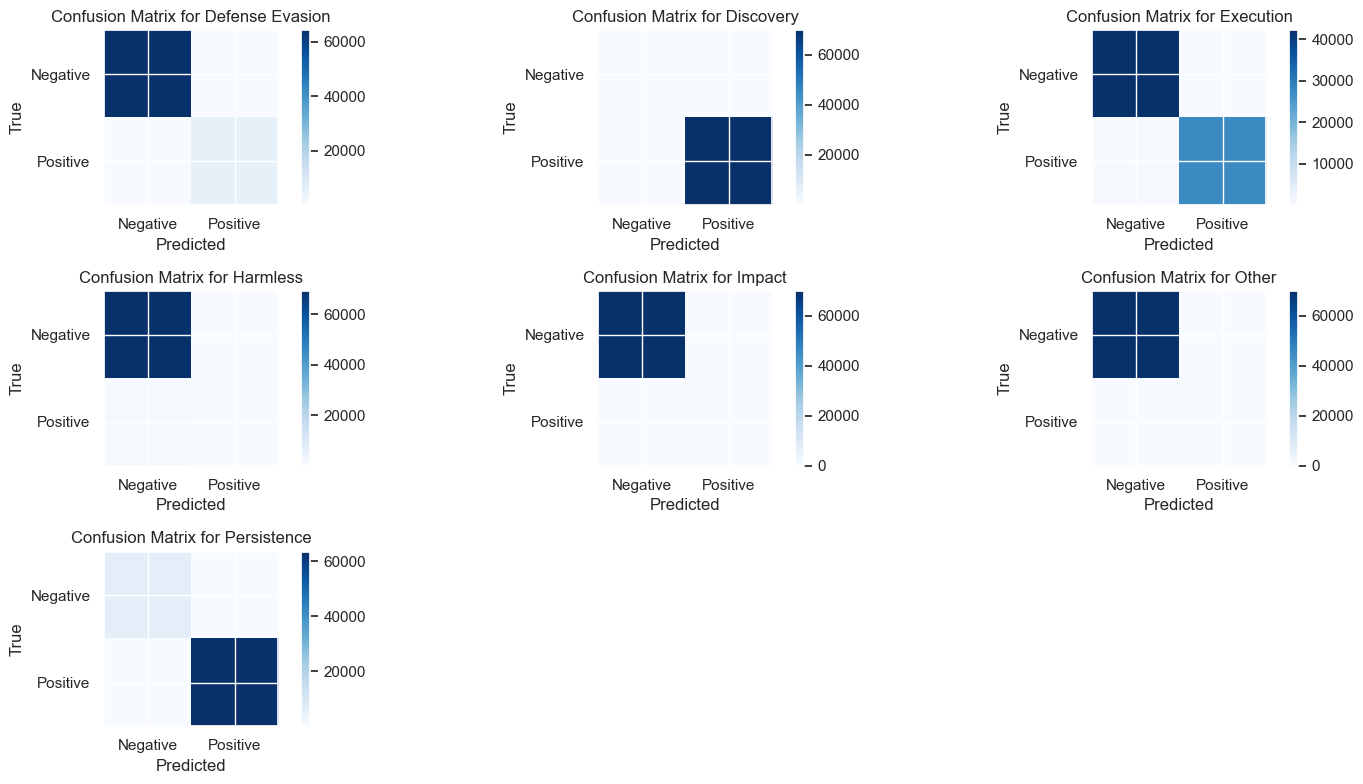

In [65]:
# Plotting the confusion matrix
plt.figure(figsize=(15, 8))
for i, label in enumerate(mlb.classes_):
    plt.subplot(3, 3, i + 1)
    plt.title(f'Confusion Matrix for {label}')
    plt.imshow(confusion[i], cmap='Blues', interpolation='nearest')
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(np.arange(2), ['Negative', 'Positive'])
    plt.yticks(np.arange(2), ['Negative', 'Positive'])

plt.tight_layout()
plt.show()

The classification report provides a comprehensive overview of key classification metrics for each label. It includes metrics such as precision, recall, F1-score, and support.
- Precision:
  -  It measures the accuracy of the positive predictions. Precision is the ratio of correctly predicted positive observations to the total predicted positives. It's calculated as TP / (TP + FP).
- Recall (Sensitivity or True Positive Rate):
  -  It measures the proportion of actual positives that were correctly predicted. Recall is the ratio of correctly predicted positive observations to the all observations in the actual class. It's calculated as TP / (TP + FN).
- F1-score:
  -  It's the harmonic mean of precision and recall. It provides a balance between precision and recall. It's calculated as 2 * (precision * recall) / (precision + recall).
- Support:
  - It's the number of actual occurrences of the class in the specified dataset.

In [60]:
report = classification_report(y_test_mlb, predictions, target_names=mlb.classes_)
print("Classification Report:")
print(report)

Classification Report:
                 precision    recall  f1-score   support

Defense Evasion       0.99      0.97      0.98      5634
      Discovery       1.00      1.00      1.00     69659
      Execution       1.00      0.99      0.99     27717
       Harmless       0.93      0.16      0.28       670
         Impact       1.00      0.50      0.67         2
          Other       1.00      0.92      0.96       103
    Persistence       1.00      1.00      1.00     63431

      micro avg       1.00      0.99      1.00    167216
      macro avg       0.99      0.79      0.84    167216
   weighted avg       1.00      0.99      0.99    167216
    samples avg       1.00      0.99      1.00    167216



**2.3 Tune the hyper-parameters of the models through cross-validation. How do performance vary?**

**2.4 Comments on the results for each on the intents.**

**2.5 Explore the possible features: try combining features differently, e.g., does tf-idf improve or worsen
performance? Think about the problem and summarize the ways you have tried (even those that
did not work).**

<left><b><font size=4>Section 3 – Unsupervised Learning – Clustering<b><left>